### Dominik Szot <br> Laboratorium 10  <br> Równania różniczkowe cząstkowe

<b> Zadanie 1. </b> <br>
Cząsteczka w dwuwymiarowej studni potencjału. Cząsteczka odbija
się od ścian dwuwymiarowej nieskończonej studni potencjału o szerokości L. <br>
Zachowanie cząsteczki opisane jest bezczasowym równaniem Schrodingera

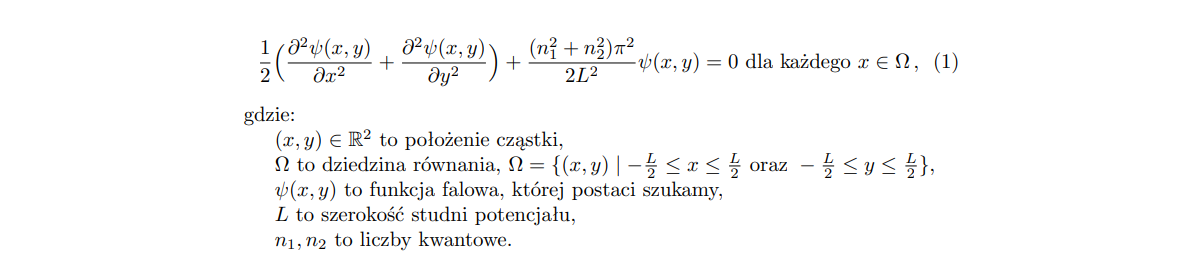

Jednostki dobrano w ten sposób, że iloraz h/m jest równy 1. Przyjmij L = 2. <br>
Warunków brzegowe zdefiniowane są następująco:

$$ 
    \psi (x,y) = 0 \ dla \ |x| = \frac {L} {2} \  lub  \ |y| = \frac {L} {2}
$$

Analityczna postać rozwiązania równania (1) z warunkami brzegowymi (2) jest
następująca:

$$ 
    \psi (x,y) = \frac {2} {L} \sin (  \frac {n_1 \pi (x +  \frac {L} {2})} {L}) \sin ( \frac {n_2 \pi (y +  \frac {L} {2})} {L}) \ dla x \in \Omega \\ 
    0 \ w \ przeciwnym \ wypadku  
$$

Rozwiąż powyższe zagadnienie brzegowe (1),(2) dla ($ n_1 $, $ n_1$) ∈ {1, 2} × {1, 2} =
{(1, 1),(1, 2),(2, 1),(2, 2)}. Do rozwiązania użyj sieci neuronowych PINN (ang.
Physics-informed Neural Network ), wykorzystując bibliotekę DeepXDE. Warstwa
wejściowa sieci powinna posiadać 4 neurony, L0 = (x, y, $ n_1 $, $ n_1$), kodujące odpowiednio położenie cząstki (x, y) oraz liczby kwantowe $ n_1 $, $ n_1$ . Jako funkcję
aktywacji przyjmij tangens hiperboliczny, tanh.

Na początku importuję potrzebne biblioteki. Korzystam z backendu torch.

In [82]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import tf

L = 2
n = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])

Funkcja obliczająca wartość rzeczywistą rozwiązania za pomocą analitycznej postaci równania

In [83]:
def psi(x,y,n1,n2):
    return (2/L)*np.sin((n1*np.pi*(x+L/2)/L))*np.sin((n2*np.pi*(y+L/2)/L))

def exact_sol(f):
    x, y, n1, n2 = f[:, 0:1], f[:, 1:2], f[:, 2:3], f[:, 3:4]
    return np.sin(n1*np.pi*(x + 1)*0.5)*np.sin(n2*np.pi*(y + 1)*0.5)

Definiuję równanie różniczkowe cząstkowe. <br>
W celu obliczenia  $ \frac { \partial ^ 2 \psi(x,y) } {\partial x^2}  $ oraz $ \frac { \partial ^ 2 \psi(x,y) } {\partial y^2} $ korzystam z funkcji `dde.grad.hessian` 

In [84]:
def pde(x,psi,n1,n2):
    laplacian = dde.grad.hessian(psi, x, i=0, j=0) + dde.grad.hessian(psi, x, i=1, j=1)
    return 1/2 * laplacian + psi * (n1**2 + n2**2) * np.pi**2/8

initial_conditions = {
    "n_1_initial_conditions" :[dde.PointSetBC([-0.5, 0.], psi(-0.5, 0, 1, 1))],   
    "n_2_initial_conditions" :[dde.PointSetBC([[0., -0.5]], 1.), dde.PointSetBC([[0., 0.5]], -1.)], 
    "n_3_initial_conditions" :[dde.PointSetBC([[-0.5, 0.]], 1.), dde.PointSetBC([[0.5, 0.]], -1.)], 
    "n_4_initial_conditions" :[
        dde.PointSetBC([[-0.5, -0.5]],1.), dde.PointSetBC([[-0.5, 0.5]], -1.),
        dde.PointSetBC([[0.5, -0.5]],-1.), dde.PointSetBC([[0.5, 0.5]], 1.), dde.PointSetBC([[0, 0]], psi(0, 0, 2, 2))
    ]
}

Następnie definiuje warunki oraz przykładowe wartości hiperparametrów zaczerpnięte z [2, str. 221].

In [85]:
def get_model(initial_conditions, pde):
    geom = dde.geometry.Rectangle([-1, -1], [1, 1])
    bc = dde.icbc.DirichletBC(geom, lambda x:0, lambda x, on_boundary: on_boundary)
    conditions = [bc]
    
    for i in initial_conditions:
        conditions.append(i)

    data = dde.data.PDE(geom, pde, conditions, num_domain= 4000, num_boundary= 2000, num_test=1000)
    activation = "tanh"
    initializer = "Glorot normal"

    net = dde.maps.FNN([2] + [40]*3 + [1], activation, initializer)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)

    losshistory, train_state = model.train(iterations=2000)
    # dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    return model


In [86]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

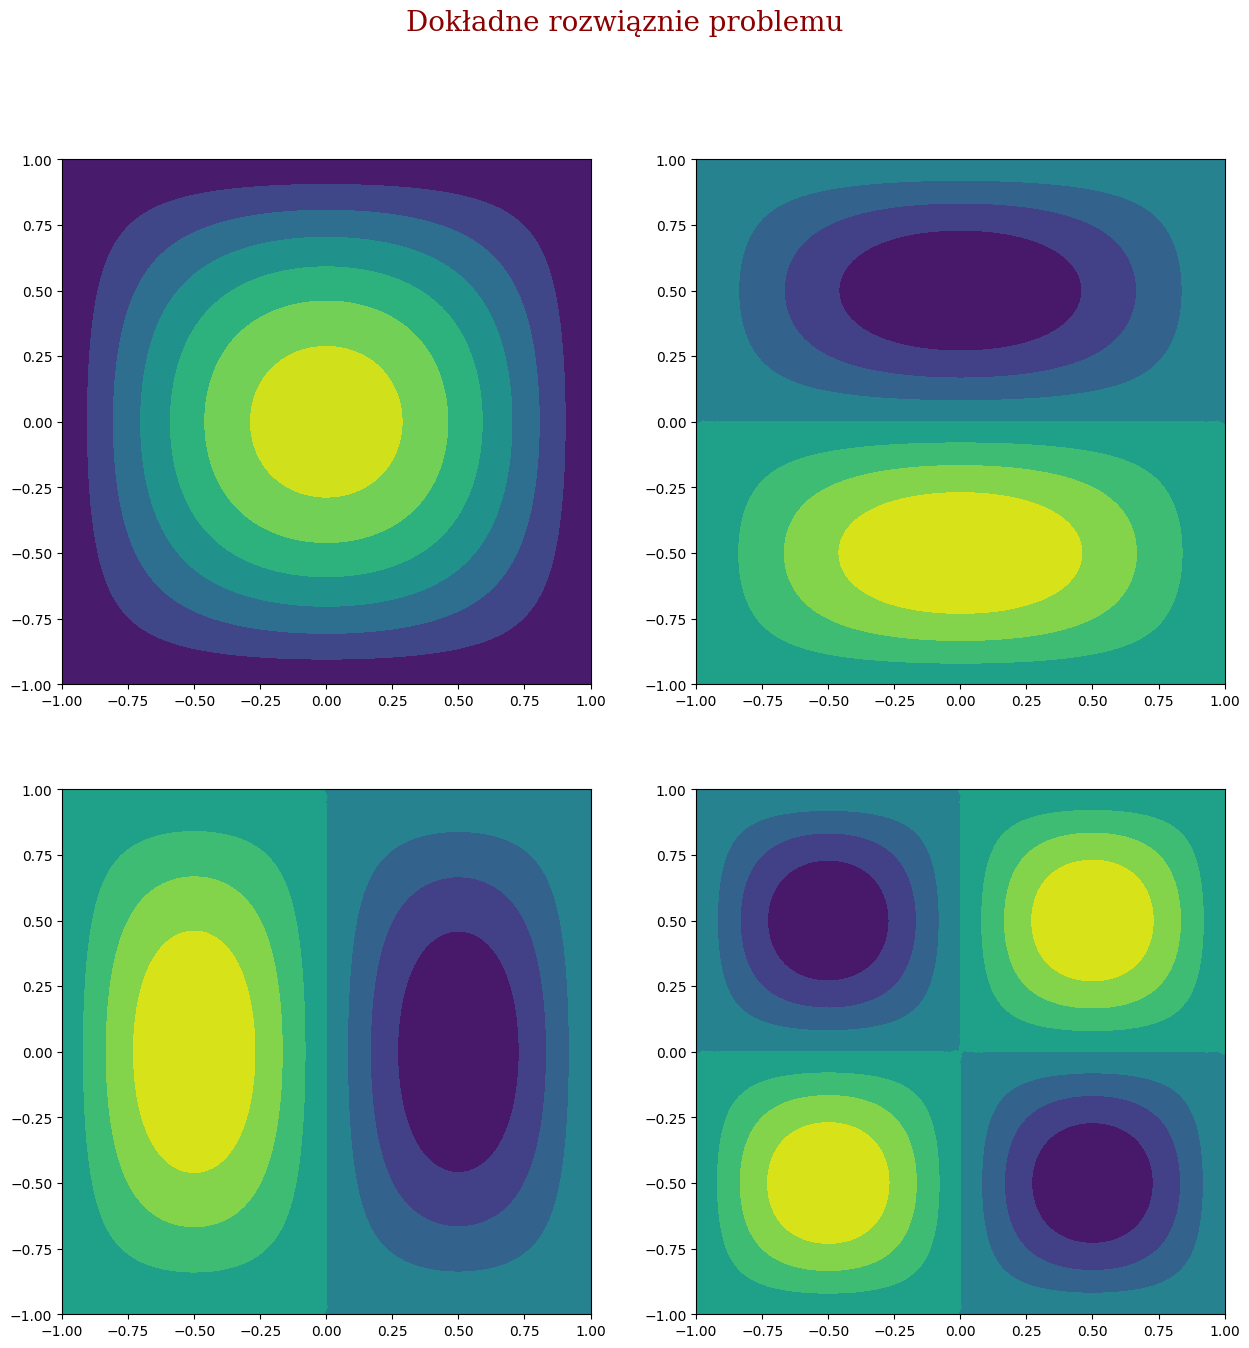

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [87]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

x_axis, y_axis = np.meshgrid(x, y)
x_axis = x_axis.reshape(-1)
y_axis = y_axis.reshape(-1)

test_domain = np.array([
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(1, len(x_axis)),  np.repeat(1, len(x_axis)))).T,
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(1, len(x_axis)),  np.repeat(2, len(x_axis)))).T,
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(2, len(x_axis)),  np.repeat(1, len(x_axis)))).T, 
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(2, len(x_axis)),  np.repeat(2, len(x_axis)))).T
])

exact_solution = np.hstack([exact_sol(el) for el in test_domain])

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 15)
fig.suptitle("Dokładne rozwiąznie problemu", fontweight='normal', font="serif", color="darkred", fontsize="20")

for i, value in enumerate(n):
    plt.figure()
    ax[value[0] - 1][value[1] - 1].tricontourf(test_domain[i,:,0], test_domain[i,:,1], exact_solution[:, i])


Compiling model...
'compile' took 0.000115 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.44e-02, 1.15e-02, 5.92e-01]    [2.43e-02, 1.15e-02, 3.60e-01]    []  
1000      [1.92e-03, 1.84e-02, 1.81e-03]    [1.57e-03, 1.84e-02, 2.95e-01]    []  
2000      [1.01e-03, 1.33e-02, 1.02e-03]    [8.82e-04, 1.33e-02, 2.74e-01]    []  

Best model at step 2000:
  train loss: 1.53e-02
  test loss: 2.89e-01
  test metric: []

'train' took 97.235950 s

Compiling model...
'compile' took 0.000126 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.14e+00, 4.65e-02, 7.47e-01, 7.47e-01]    [8.18e-01, 4.65e-02, 7.47e-01, 7.47e-01]    []  
1000      [2.25e-02, 6.82e-03, 3.63e-04, 3.49e-04]    [2.29e-02, 6.82e-03, 3.63e-04, 3.49e-04]    []  
2000      [5.29e-03, 2.16e-03, 5.62e-05, 5.76e-05]    [5.72e-03, 2.16e-03, 5.62e-05, 5.76e-05]    [

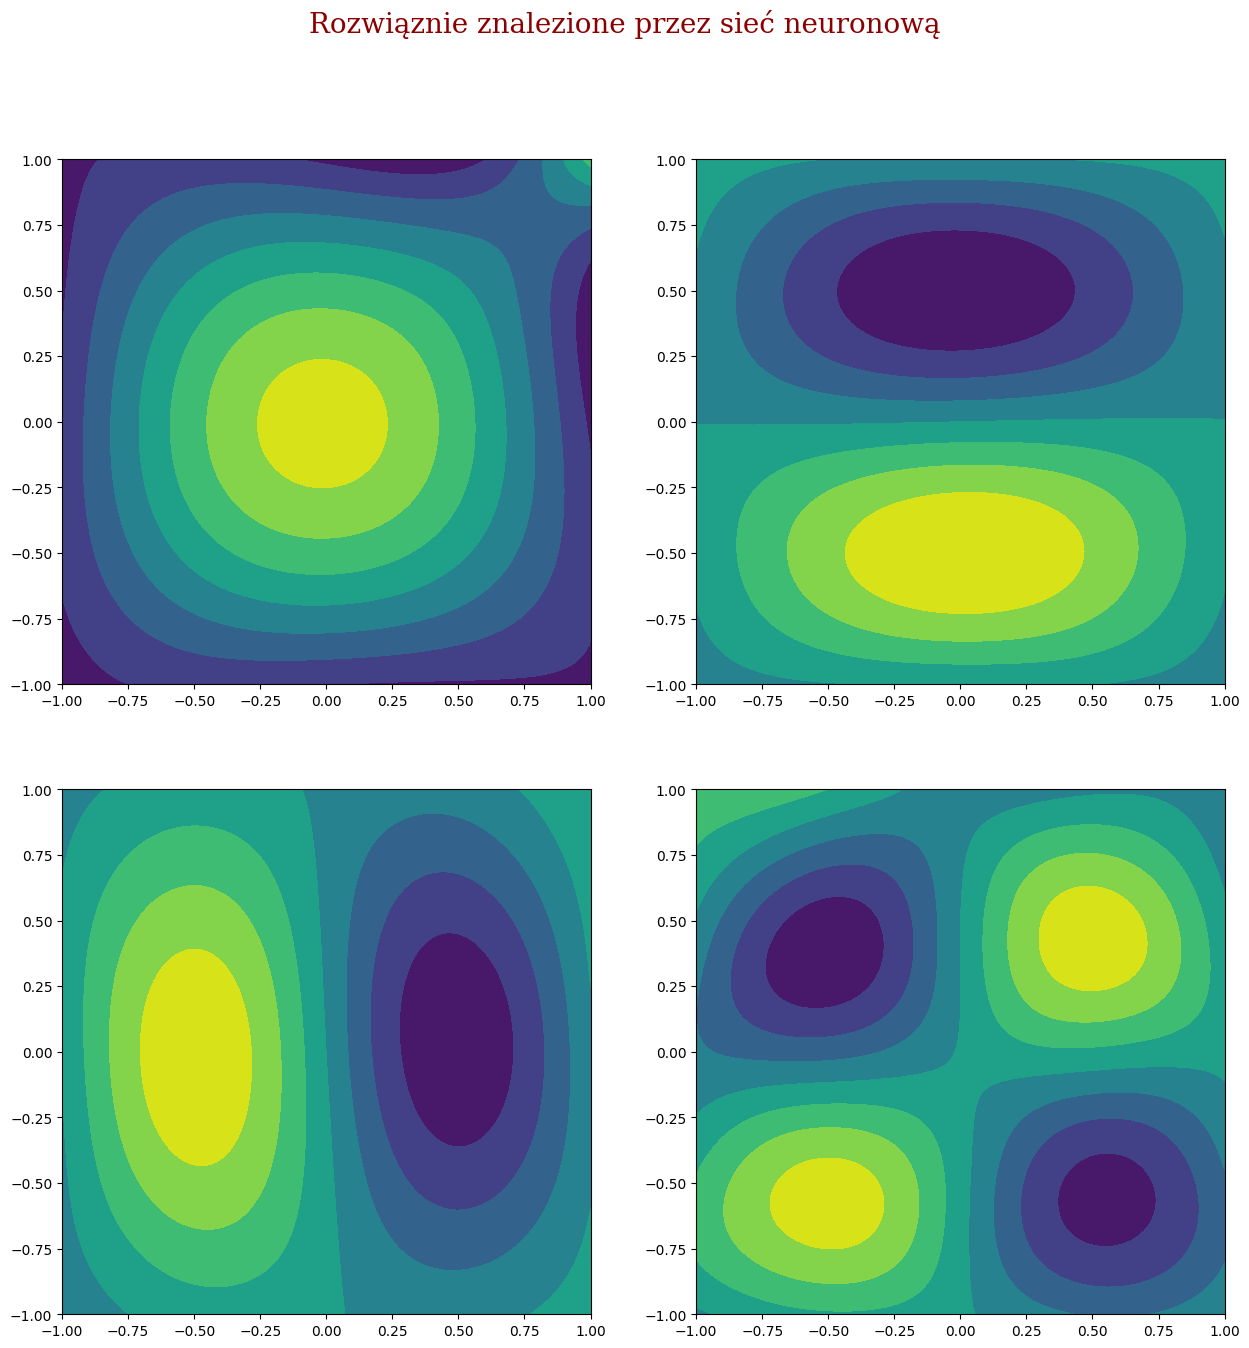

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [88]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.suptitle("Rozwiąznie znalezione przez sieć neuronową", fontweight='normal', font="serif", color="darkred", fontsize="20")

solutions = []

fig.set_size_inches(15, 15)
for i, value in enumerate(n):
    plt.figure()
    
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)

    x_grid, y_grid = np.meshgrid(x, y)
    points = np.vstack([x_grid.flatten(), y_grid.flatten()]).T
    
    x_grid = x_grid.reshape(-1)
    x_grid = x_grid.reshape(-1)
        
    model = get_model(initial_conditions[f"n_{i+1}_initial_conditions"], lambda x, psi: pde(x, psi, n[i][0], n[i][1]))
    solutions.append(model.predict(points).reshape(x_grid.shape))
    
    ax[value[0]-1][value[1]-1].tricontourf(np.ravel(x_grid), np.ravel(y_grid), solutions[i])

/home/dominiq/.local/lib/python3.10/site-packages/matplotlib/tri/_triangulation.py:179: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


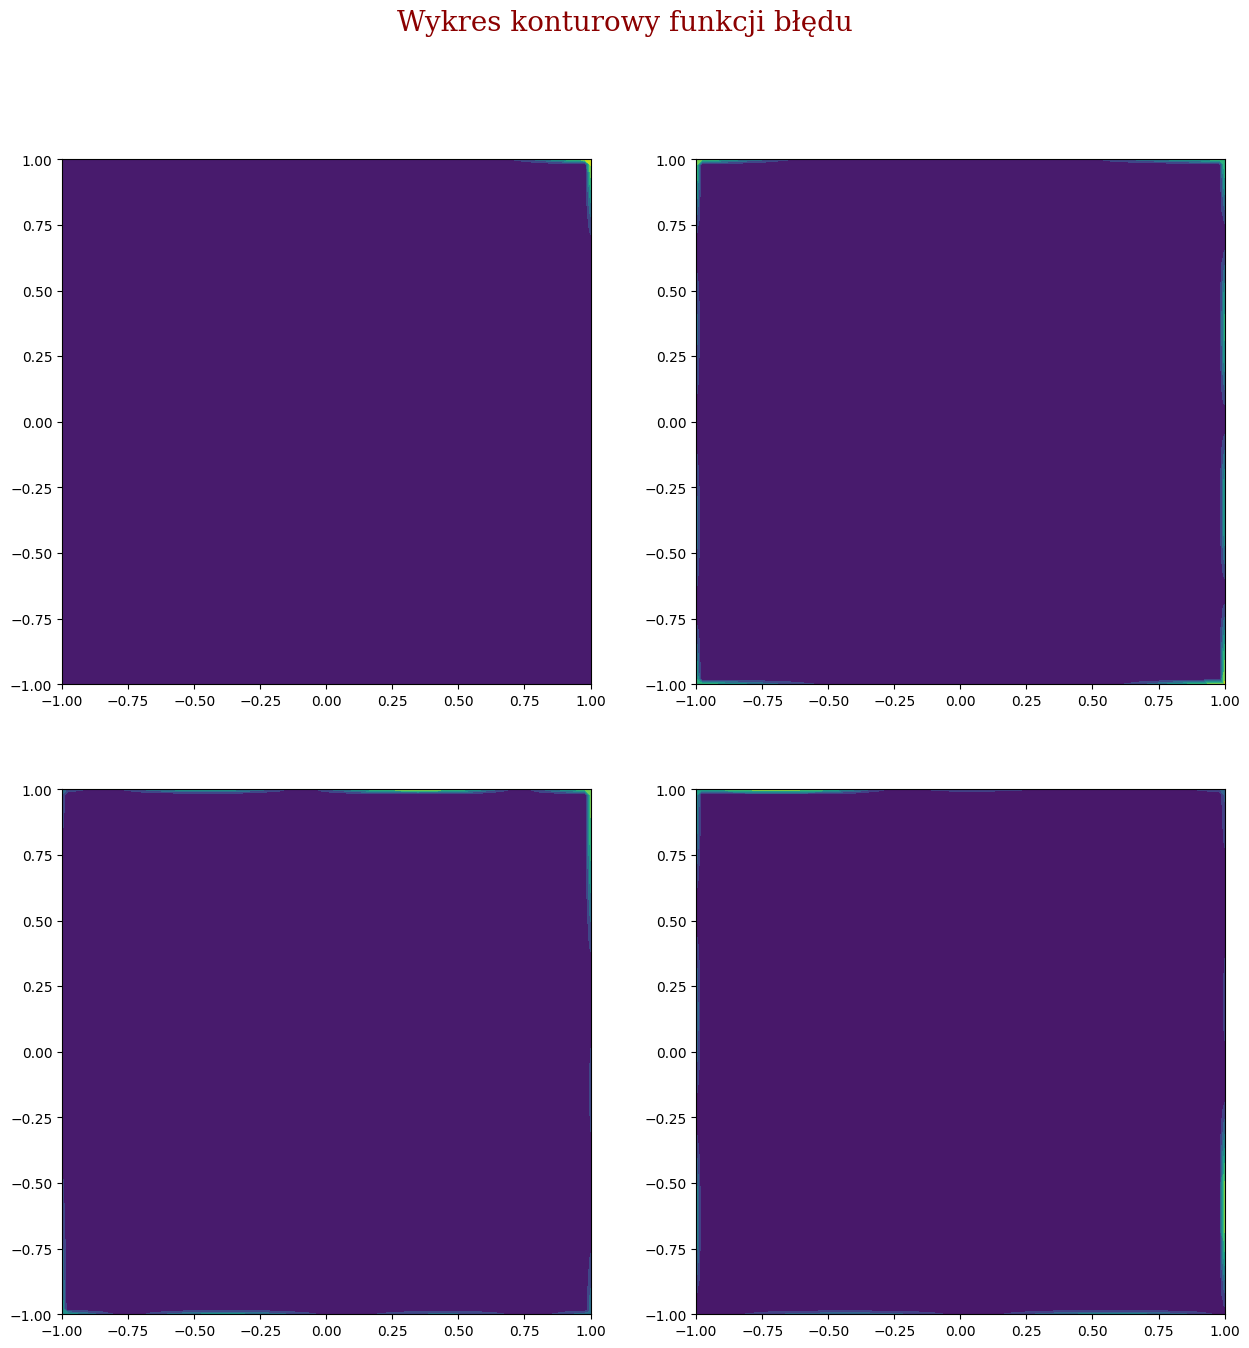

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [89]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

x_axis, y_axis = np.meshgrid(x, y)
x_axis = x_axis.reshape(-1)
y_axis = y_axis.reshape(-1)

test_domain = np.array([
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(1, len(x_axis)),  np.repeat(1, len(x_axis)))).T,
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(2, len(x_axis)),  np.repeat(1, len(x_axis)))).T,
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(1, len(x_axis)),  np.repeat(2, len(x_axis)))).T, 
    np.vstack((np.ravel(x_axis), np.ravel(y_axis), np.repeat(2, len(x_axis)),  np.repeat(2, len(x_axis)))).T
])

exact_solution = np.hstack([exact_sol(el) for el in test_domain])

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 15)
fig.suptitle("Wykres konturowy funkcji błędu", fontweight='normal', font="serif", color="darkred", fontsize="20")

for i, value in enumerate(n):
    plt.figure()
    ax[value[0] - 1][value[1] - 1].tricontourf(test_domain[i,:,0], test_domain[i,:,1], (solutions[i] - exact_solution[:, i])/(exact_solution[:, i]+ 1e-15)**2)

Bibliografia:
* Materiały z zajęc
* [2] Lu Lu, Xuhui Meng, Zhiping Mao, George Em Karniadakis DeepXDE: A
Deep Learning Library for Solving Differential Equations